In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

layers = tf.keras.layers
models = tf.keras.models

In [19]:
# --- Konfigurasi GPU (Sama seperti notebook Anda) ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [20]:
train_dir = "../dataset/train"
val_dir   = "../dataset/val"
test_dir  = "../dataset/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 4  # bika ambon, kerak telur, papeda, plecing kangkung
CLASS_NAMES_ORDER = ["bika ambon", "kerak telur", "papeda", "plecing kangkung"]
EPOCHS = 10

In [21]:
allowed_ext = [".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"]
root_dirs = [train_dir, val_dir, test_dir]

In [22]:
# --- Memuat Dataset (Sama seperti notebook Anda) ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 241 files belonging to 4 classes.


Found 29 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Class names: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


In [23]:
# Preprocessing Dataset (FUNGSI PREPARE DIUBAH) ---
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False):
    # Menggunakan fungsi bawaan VGG16 untuk preprocessing
    ds = ds.map(lambda x, y: (preprocess_input(x), y), 
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prep = prepare(train_ds, shuffle=True)
val_ds_prep   = prepare(val_ds, shuffle=False)
test_ds_prep  = prepare(test_ds, shuffle=False)

print("Banyak batch train:", tf.data.experimental.cardinality(train_ds).numpy())
print("Banyak batch val  :", tf.data.experimental.cardinality(val_ds).numpy())
print("Banyak batch test :", tf.data.experimental.cardinality(test_ds).numpy())

RuntimeError: Random ops require a seed to be set when determinism is enabled. Please set a seed before running the op, e.g. by calling tf.random.set_seed(1).

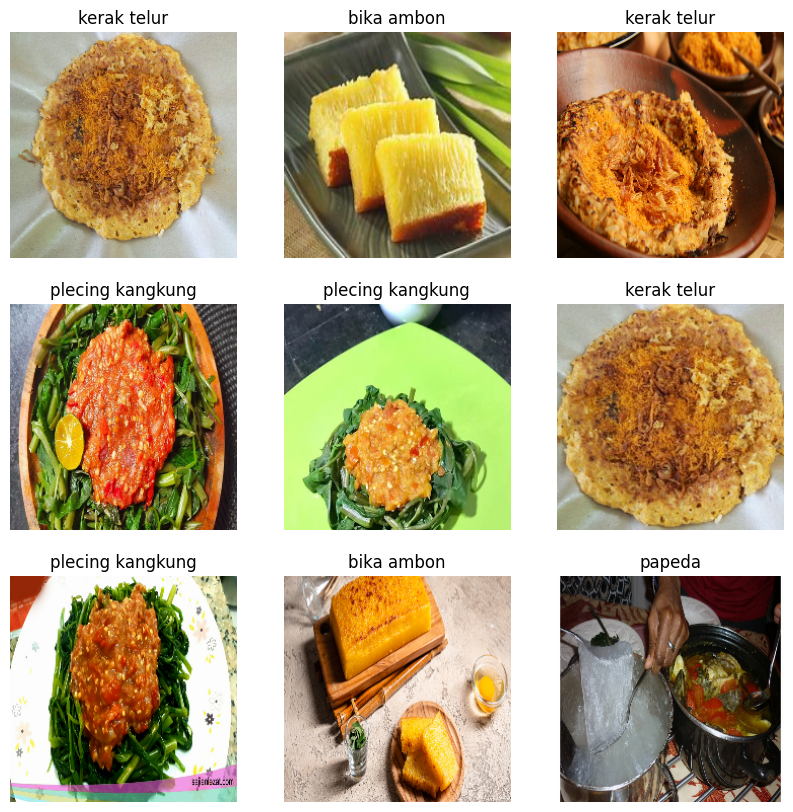

In [ ]:
# --- PERUBAHAN: Visualisasi (Mengambil dari 'train_ds' asli) ---
# Ini untuk menampilkan gambar dengan warna yang benar (tidak "aneh")
plt.figure(figsize=(10, 10))
# Mengambil dari train_ds (asli) BUKAN train_ds_prep
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Tampilkan gambar (format RGB [0, 255] asli)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

def visualize_data(dataset, n=9):
    plt.figure(figsize=(8,8))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")


In [ ]:
# --- PERUBAHAN: ARSITEKTUR MODEL (VGG16) ---

# 1. Muat base model VGG16
base_model = VGG16(weights=None,
                   include_top=False,  # Jangan sertakan classifier aslinya
                   input_shape=(224,224,3)) # Gunakan bobot dari ImageNet

# 2. Bekukan (freeze) bobot dari VGG16
base_model.trainable = False

# 3. Buat model baru
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

# --- Kompilasi Model (Sama seperti notebook Anda) ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# --- Callbacks (Mengganti nama file H5) ---
# --- PERUBAHAN ---
# Mengganti nama file agar tidak menimpa model lama Anda
os.makedirs("../models", exist_ok=True)
save_path = "../models/BestModel_VGG16_KERAS.h5.keras" 

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    mode='min', 
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path, 
    monitor='val_accuracy', 
    mode='max', 
    save_best_only=True, 
    verbose=1
)

In [ ]:
# --- Pelatihan Model (Sama seperti notebook Anda) ---
history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2304 - loss: 3.5775
Epoch 1: val_accuracy improved from -inf to 0.24138, saving model to ../models/BestModel_VGG16_KERAS.h5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.2349 - loss: 3.7851 - val_accuracy: 0.2414 - val_loss: 2.3046
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2612 - loss: 2.6508
Epoch 2: val_accuracy improved from 0.24138 to 0.27586, saving model to ../models/BestModel_VGG16_KERAS.h5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.2604 - loss: 2.6305 - val_accuracy: 0.2759 - val_loss: 1.8071
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2953 - loss: 2.1567
Epoch 3: val_accuracy did not improve from 0.27586
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.2910 - loss: 2.1358 - val_accuracy: 0.2414 - val_loss: 1.5257
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3200 - loss: 1.6603
Epoch 4: val_accuracy improved from 0.27586 to 0.55172, saving 

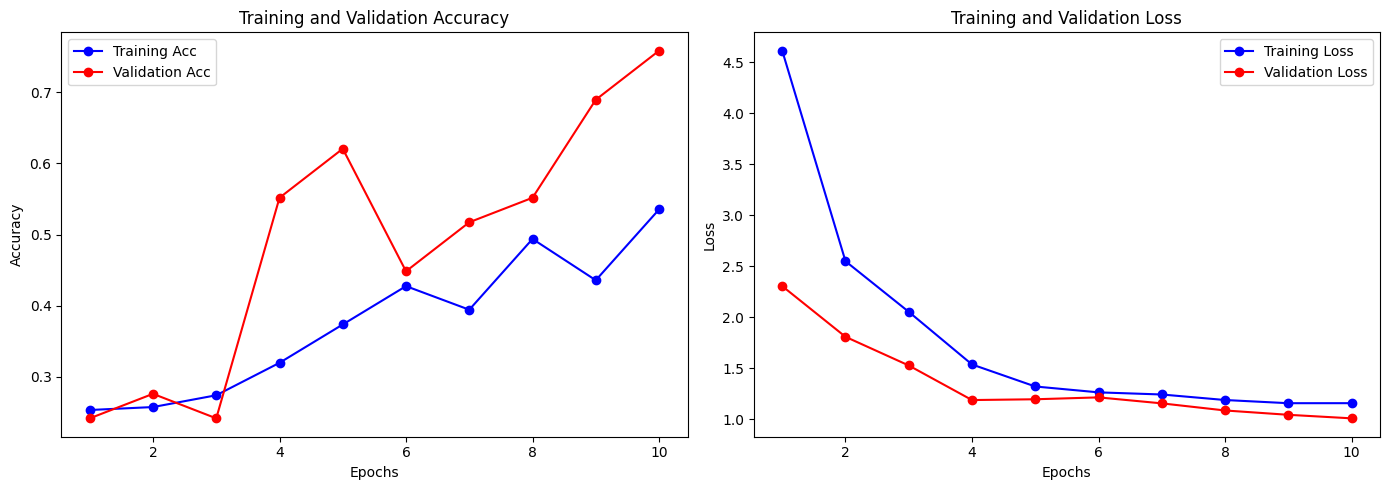

In [ ]:
# --- Plot Akurasi dan Loss (Sama seperti notebook Anda) ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# --- Evaluasi Model (Sama, otomatis menggunakan save_path baru) ---
print("\n--- Evaluasi Model ---")
# Muat bobot terbaik yang disimpan
model.load_weights(save_path) 

# Evaluasi pada data tes
test_loss, test_acc = model.evaluate(test_ds_prep, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


--- Evaluasi Model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6129 - loss: 1.1351
Test Accuracy: 61.29%
Test Loss: 1.1351



--- Laporan Klasifikasi & Confusion Matrix (Data Tes) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
                  precision    recall  f1-score   support

      bika ambon       0.80      0.50      0.62         8
     kerak telur       0.67      0.29      0.40         7
          papeda       0.50      0.88      0.64         8
plecing kangkung       0.67      0.75      0.71         8

        accuracy                           0.61        31
       macro avg       0.66      0.60      0.59        31
    weighted avg       0.66      0.61      0.60        31



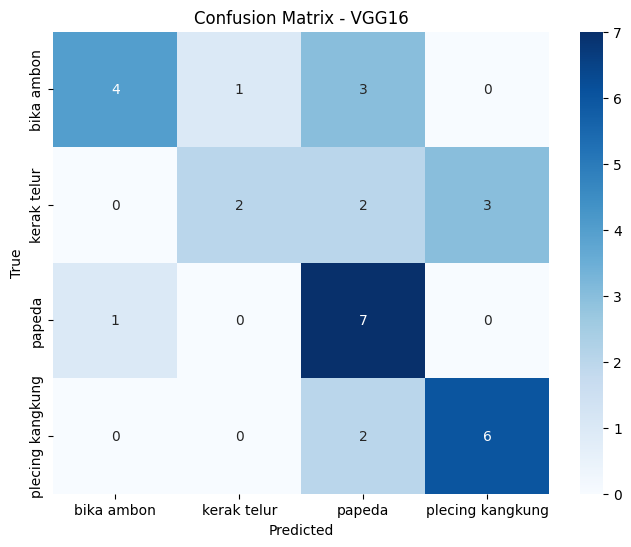

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


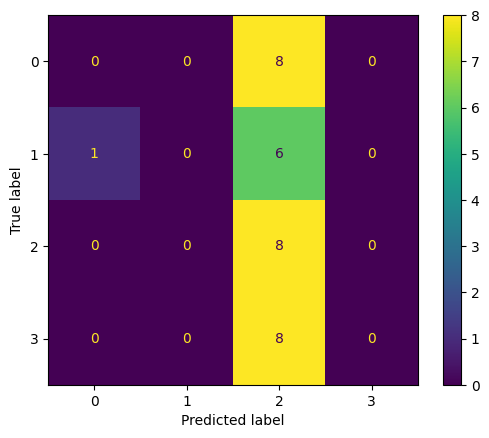

In [ ]:

# --- PERUBAHAN: Confusion Matrix & Classification Report (Kode Baru Anda) ---
# Menghapus fungsi 'plot_confusion_matrix' lama dan mengganti dengan ini
# untuk memperbaiki NameError.

print("\n--- Laporan Klasifikasi & Confusion Matrix (Data Tes) ---")

# Inisialisasi list
y_true = []
y_pred = []

# Ganti 'test_eval_ds' menjadi 'test_ds_prep'
for images, labels in test_ds_prep:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - VGG16") # Judul diubah
plt.show()



--- Menampilkan Hasil Prediksi (Data Tes - ACAK) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


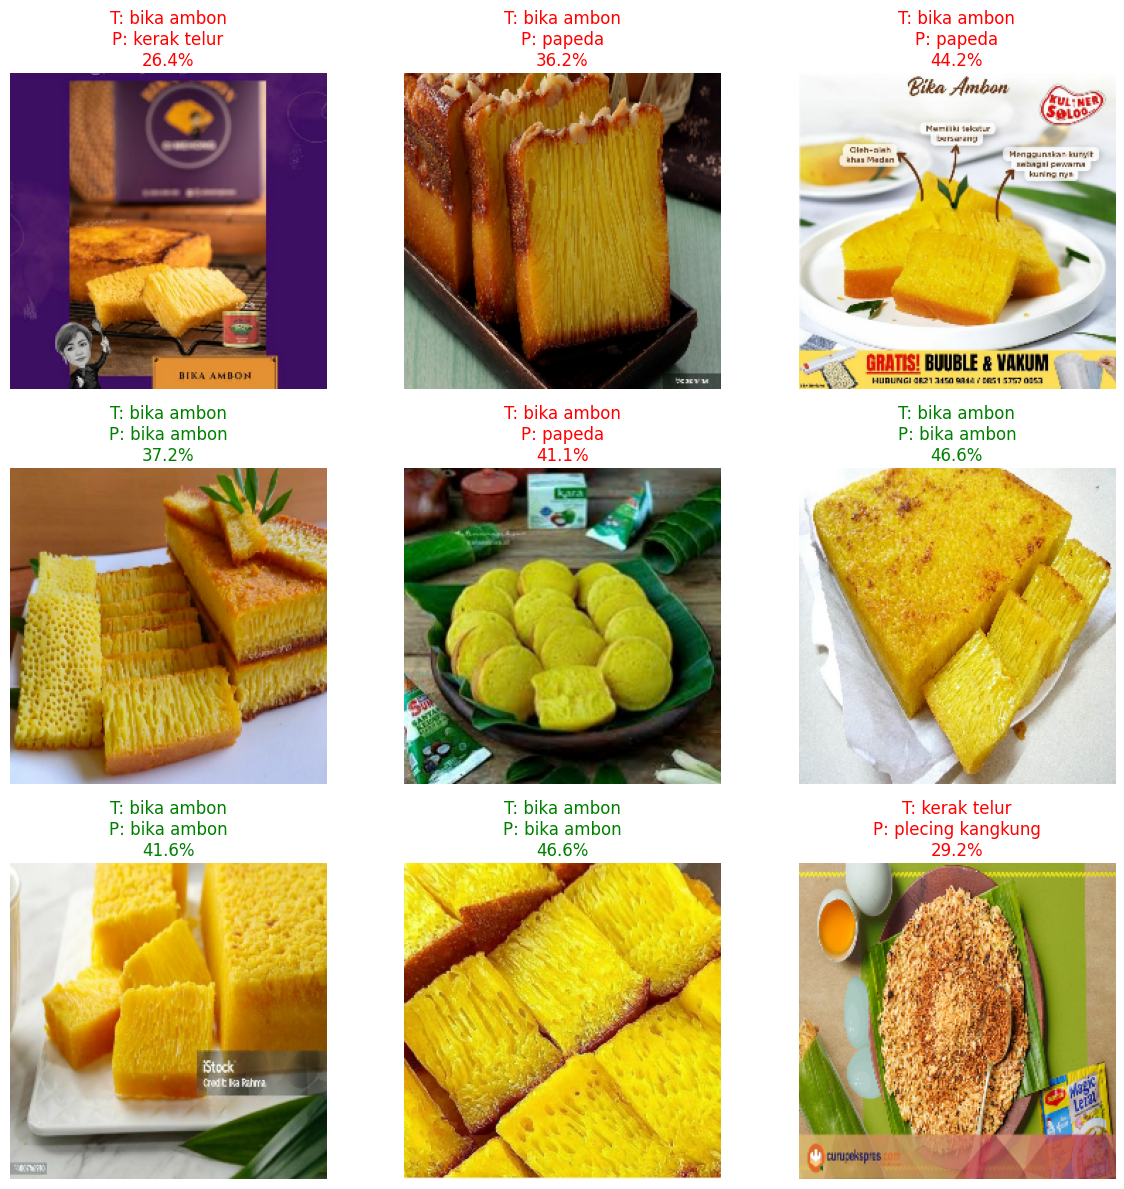

In [ ]:
# --- PERUBAHAN: Menampilkan Hasil Prediksi (Data Tes - ACAK) ---
# Kode ini diubah agar menampilkan gambar acak setiap dijalankan

print("\n--- Menampilkan Hasil Prediksi (Data Tes - ACAK) ---")

# Menyiapkan area plot
plt.figure(figsize=(12, 12))

try:
    # 1. 'zip' (gabungkan) dataset gambar asli dengan dataset VGG
    zipped_ds = tf.data.Dataset.zip((test_ds, test_ds_prep))
    
    # 2. Acak (shuffle) dataset gabungan, lalu ambil 1 batch
    for (images_asli, labels_asli), (images_prep, _) in zipped_ds.shuffle(buffer_size=100).take(1):
        
        # 3. Lakukan prediksi pada batch yang sudah di-preprocess (VGG16)
        predictions = model.predict(images_prep)
        pred_labels = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1) * 100

        # Loop untuk 9 gambar pertama di batch ini
        for i in range(9):
            if i >= len(images_asli): # Pengaman jika batch < 9
                break 
                
            ax = plt.subplot(3, 3, i + 1)
            
            # 4. Tampilkan gambar ASLI (dari 'test_ds')
            plt.imshow(images_asli[i].numpy().astype('uint8'))
            
            # Ambil nama label
            true_label = class_names[labels_asli[i]]
            pred_label = class_names[pred_labels[i]]
            conf = confidences[i]
            
            # 5. Beri warna hijau jika benar, merah jika salah
            color = 'green' if true_label == pred_label else 'red'
            
            # 6. Buat judul/title
            plt.title(f"T: {true_label}\nP: {pred_label}\n{conf:.1f}%", color=color)
            plt.axis("off")
            
except Exception as e:
    print(f"Terjadi error: {e}")
    print("Pastikan 'test_ds', 'test_ds_prep', 'model', dan 'class_names' sudah didefinisikan.")

plt.tight_layout()
plt.show()

In [ ]:
tf.keras.models.save_model(model, '../models/BestModel_VGG16_KEL.h5', include_optimizer=False)